In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import warnings
from statsmodels.tsa.stattools import adfuller, acf
warnings.filterwarnings("ignore")


# df = pd.read_csv(r"/home/daksh/Desktop/pumpfun_10-03-2025_to_10-07-2025.csv/pumpfun_10-03-2025_to_10-07-2025.csv",engine='pyarrow')
# /home/daksh/Downloads/pumpfun_09-08-2025_to_09-11-2025.csv/pumpfun_09-08-2025_to_09-11-2025.csv
# /home/daksh/Desktop/pumpfun_10-03-2025_to_10-07-2025.csv/pumpfun_10-03-2025_to_10-07-2025.csv

In [3]:
df.head()

NameError: name 'df' is not defined

In [4]:
def load_and_prepare_data(filepath):
    """Load and prepare the crypto trading data"""
    df = pd.read_csv(filepath)
    
    # Parse datetime - adjust column name if different
    date_col = [col for col in df.columns if 'date' in col.lower()][0]
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)
    
    # Clean column names
    df.columns = df.columns.str.strip()
    
    return df

# Load your two datasets
df1 = load_and_prepare_data('/home/daksh/Downloads/pumpfun_09-08-2025_to_09-11-2025.csv/pumpfun_09-08-2025_to_09-11-2025.csv')  # Good performance
df2 = load_and_prepare_data('/home/daksh/Desktop/pumpfun_10-03-2025_to_10-07-2025.csv/pumpfun_10-03-2025_to_10-07-2025.csv')  # Poor performance

In [5]:
# ============================================================================
# 1. HURST EXPONENT - MOST CRITICAL TEST
# ============================================================================

def calculate_hurst_exponent(prices, max_lag=20):
    """
    Calculate Hurst Exponent
    H < 0.5: Mean-reverting (good for mean reversion strategy)
    H = 0.5: Random walk (no edge)
    H > 0.5: Trending (bad for mean reversion)
    """
    lags = range(2, max_lag)
    tau = []
    
    for lag in lags:
        # Calculate the standard deviation of the differences
        pp = np.subtract(prices[lag:], prices[:-lag])
        tau.append(np.std(pp))
    
    # Linear fit to log-log plot
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    hurst = reg[0]
    
    return hurst


In [6]:
def analyze_token_mean_reversion(df, token_address):
    """Analyze if a specific token exhibits mean reversion"""
    token_data = df[df['Token Address'] == token_address].copy()
    
    if len(token_data) < 50:
        return None
    
    # Sort by time
    token_data = token_data.sort_values(token_data.columns[0])
    prices = token_data['Token Price'].values
    
    # Remove zeros and infinities
    prices = prices[np.isfinite(prices) & (prices > 0)]
    
    if len(prices) < 30:
        return None
    
    # Log prices for better analysis
    log_prices = np.log(prices)
    
    # Calculate Hurst
    hurst = calculate_hurst_exponent(prices, min(len(prices)//2, 50))
    
    # ADF test for stationarity
    adf_result = adfuller(log_prices, maxlag=min(10, len(log_prices)//3))
    
    # Autocorrelation
    autocorr = acf(np.diff(log_prices), nlags=min(10, len(log_prices)//3))
    
    return {
        'token': token_address,
        'n_trades': len(token_data),
        'hurst': hurst,
        'adf_statistic': adf_result[0],
        'adf_pvalue': adf_result[1],
        'is_stationary': adf_result[1] < 0.05,
        'autocorr_lag1': autocorr[1] if len(autocorr) > 1 else np.nan,
        'price_volatility': np.std(np.diff(log_prices)),
        'mean_price': np.mean(prices),
        'price_range': np.max(prices) / np.min(prices)
    }


In [7]:
# ============================================================================
# 2. DATASET-LEVEL REGIME COMPARISON
# ============================================================================

def compare_datasets(df1, df2, dataset1_name='Dataset 1 (Good)', dataset2_name='Dataset 2 (Poor)'):
    """Compare overall regime characteristics"""
    
    print("=" * 80)
    print("DATASET REGIME COMPARISON - CRITICAL DIAGNOSTICS")
    print("=" * 80)
    
    results = []
    
    for df, name in [(df1, dataset1_name), (df2, dataset2_name)]:
        # Get unique tokens
        tokens = df['Token Address'].unique()
        
        print(f"\n{name}:")
        print(f"  Unique tokens: {len(tokens)}")
        print(f"  Total transactions: {len(df)}")
        
        # Analyze each token
        token_results = []
        for token in tokens[:100]:  # Limit to first 100 tokens for speed
            result = analyze_token_mean_reversion(df, token)
            if result:
                token_results.append(result)
        
        if not token_results:
            print("  WARNING: Not enough data for analysis")
            continue
            
        token_df = pd.DataFrame(token_results)
        
        # Aggregate statistics
        avg_hurst = token_df['hurst'].mean()
        pct_stationary = (token_df['is_stationary'].sum() / len(token_df)) * 100
        avg_autocorr = token_df['autocorr_lag1'].mean()
        avg_volatility = token_df['price_volatility'].mean()
        
        print(f"\n  REGIME INDICATORS:")
        print(f"    Average Hurst Exponent: {avg_hurst:.3f}", end="")
        
        # Interpret Hurst
        if avg_hurst < 0.4:
            print(" ✓ (STRONG mean-reverting)")
        elif avg_hurst < 0.5:
            print(" ✓ (Mean-reverting)")
        elif avg_hurst < 0.6:
            print(" ✗ (Random walk - NO EDGE)")
        else:
            print(" ✗✗ (TRENDING - STRATEGY WILL FAIL)")
        
        print(f"    Stationary tokens: {pct_stationary:.1f}%", end="")
        print(" ✓" if pct_stationary > 50 else " ✗")
        
        print(f"    Avg autocorrelation (lag-1): {avg_autocorr:.3f}", end="")
        print(" ✓" if avg_autocorr < 0 else " ✗")
        
        print(f"    Avg log-return volatility: {avg_volatility:.4f}")
        
        results.append({
            'dataset': name,
            'n_tokens': len(tokens),
            'n_analyzed': len(token_df),
            'avg_hurst': avg_hurst,
            'pct_stationary': pct_stationary,
            'avg_autocorr': avg_autocorr,
            'avg_volatility': avg_volatility,
            'token_results': token_df
        })
    
    return results

In [8]:
# ============================================================================
# 3. VISUALIZATIONS
# ============================================================================

def plot_regime_comparison(results):
    """Create visualization comparing the two datasets"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Dataset Regime Comparison', fontsize=16, fontweight='bold')
    
    for idx, result in enumerate(results):
        token_df = result['token_results']
        color = 'green' if idx == 0 else 'red'
        
        # Hurst distribution
        axes[idx, 0].hist(token_df['hurst'], bins=30, alpha=0.7, color=color, edgecolor='black')
        axes[idx, 0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Random Walk')
        axes[idx, 0].axvline(token_df['hurst'].mean(), color='blue', linestyle='-', linewidth=2, label='Mean')
        axes[idx, 0].set_xlabel('Hurst Exponent')
        axes[idx, 0].set_ylabel('Frequency')
        axes[idx, 0].set_title(f'{result["dataset"]}\nHurst Distribution')
        axes[idx, 0].legend()
        axes[idx, 0].grid(alpha=0.3)
        
        # Add shaded regions
        axes[idx, 0].axvspan(-0.1, 0.5, alpha=0.1, color='green', label='Mean-reverting')
        axes[idx, 0].axvspan(0.5, 1.1, alpha=0.1, color='red', label='Trending')
        
        # Autocorrelation distribution
        axes[idx, 1].hist(token_df['autocorr_lag1'].dropna(), bins=30, alpha=0.7, color=color, edgecolor='black')
        axes[idx, 1].axvline(0, color='black', linestyle='--', linewidth=2)
        axes[idx, 1].set_xlabel('Autocorrelation (Lag-1)')
        axes[idx, 1].set_ylabel('Frequency')
        axes[idx, 1].set_title(f'Autocorrelation Distribution\n(Negative = Mean-reverting)')
        axes[idx, 1].grid(alpha=0.3)
        
        # Volatility distribution
        axes[idx, 2].hist(np.log10(token_df['price_volatility']), bins=30, alpha=0.7, color=color, edgecolor='black')
        axes[idx, 2].set_xlabel('Log10(Volatility)')
        axes[idx, 2].set_ylabel('Frequency')
        axes[idx, 2].set_title('Volatility Distribution')
        axes[idx, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('regime_comparison.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved as 'regime_comparison.png'")
    plt.show()

In [9]:
# ============================================================================
# 4. HALF-LIFE OF MEAN REVERSION
# ============================================================================

def calculate_halflife(prices):
    """Calculate half-life of mean reversion using OU process"""
    log_prices = np.log(prices)
    lagged_prices = log_prices[:-1]
    delta_prices = np.diff(log_prices)
    
    # Regression: Δy = λ(μ - y_{t-1})
    # Simplified: Δy = α + β*y_{t-1}
    X = np.column_stack([np.ones(len(lagged_prices)), lagged_prices])
    
    try:
        coeffs = np.linalg.lstsq(X, delta_prices, rcond=None)[0]
        halflife = -np.log(2) / coeffs[1]
        return halflife if halflife > 0 else np.nan
    except:
        return np.nan

def analyze_halflives(df):
    """Analyze half-life distribution across tokens"""
    tokens = df['Token Address'].unique()
    halflives = []
    
    for token in tokens[:50]:  # Sample
        token_data = df[df['Token Address'] == token].copy()
        if len(token_data) < 30:
            continue
        
        token_data = token_data.sort_values(token_data.columns[0])
        prices = token_data['Token Price'].values
        prices = prices[np.isfinite(prices) & (prices > 0)]
        
        if len(prices) >= 30:
            hl = calculate_halflife(prices)
            if np.isfinite(hl) and 0 < hl < 1000:
                halflives.append(hl)
    
    if halflives:
        print(f"\n  Half-life of mean reversion:")
        print(f"    Median: {np.median(halflives):.1f} trades")
        print(f"    Mean: {np.mean(halflives):.1f} trades")
        return halflives
    return []

DATASET REGIME COMPARISON - CRITICAL DIAGNOSTICS

Dataset 1 (Good):
  Unique tokens: 675
  Total transactions: 9714739

  REGIME INDICATORS:
    Average Hurst Exponent: 0.426 ✓ (Mean-reverting)
    Stationary tokens: 15.0% ✗
    Avg autocorrelation (lag-1): -0.193 ✓
    Avg log-return volatility: 0.0791

Dataset 2 (Poor):
  Unique tokens: 443
  Total transactions: 5057313

  REGIME INDICATORS:
    Average Hurst Exponent: 0.382 ✓ (STRONG mean-reverting)
    Stationary tokens: 24.0% ✗
    Avg autocorrelation (lag-1): -0.223 ✓
    Avg log-return volatility: 0.0888

✓ Visualization saved as 'regime_comparison.png'


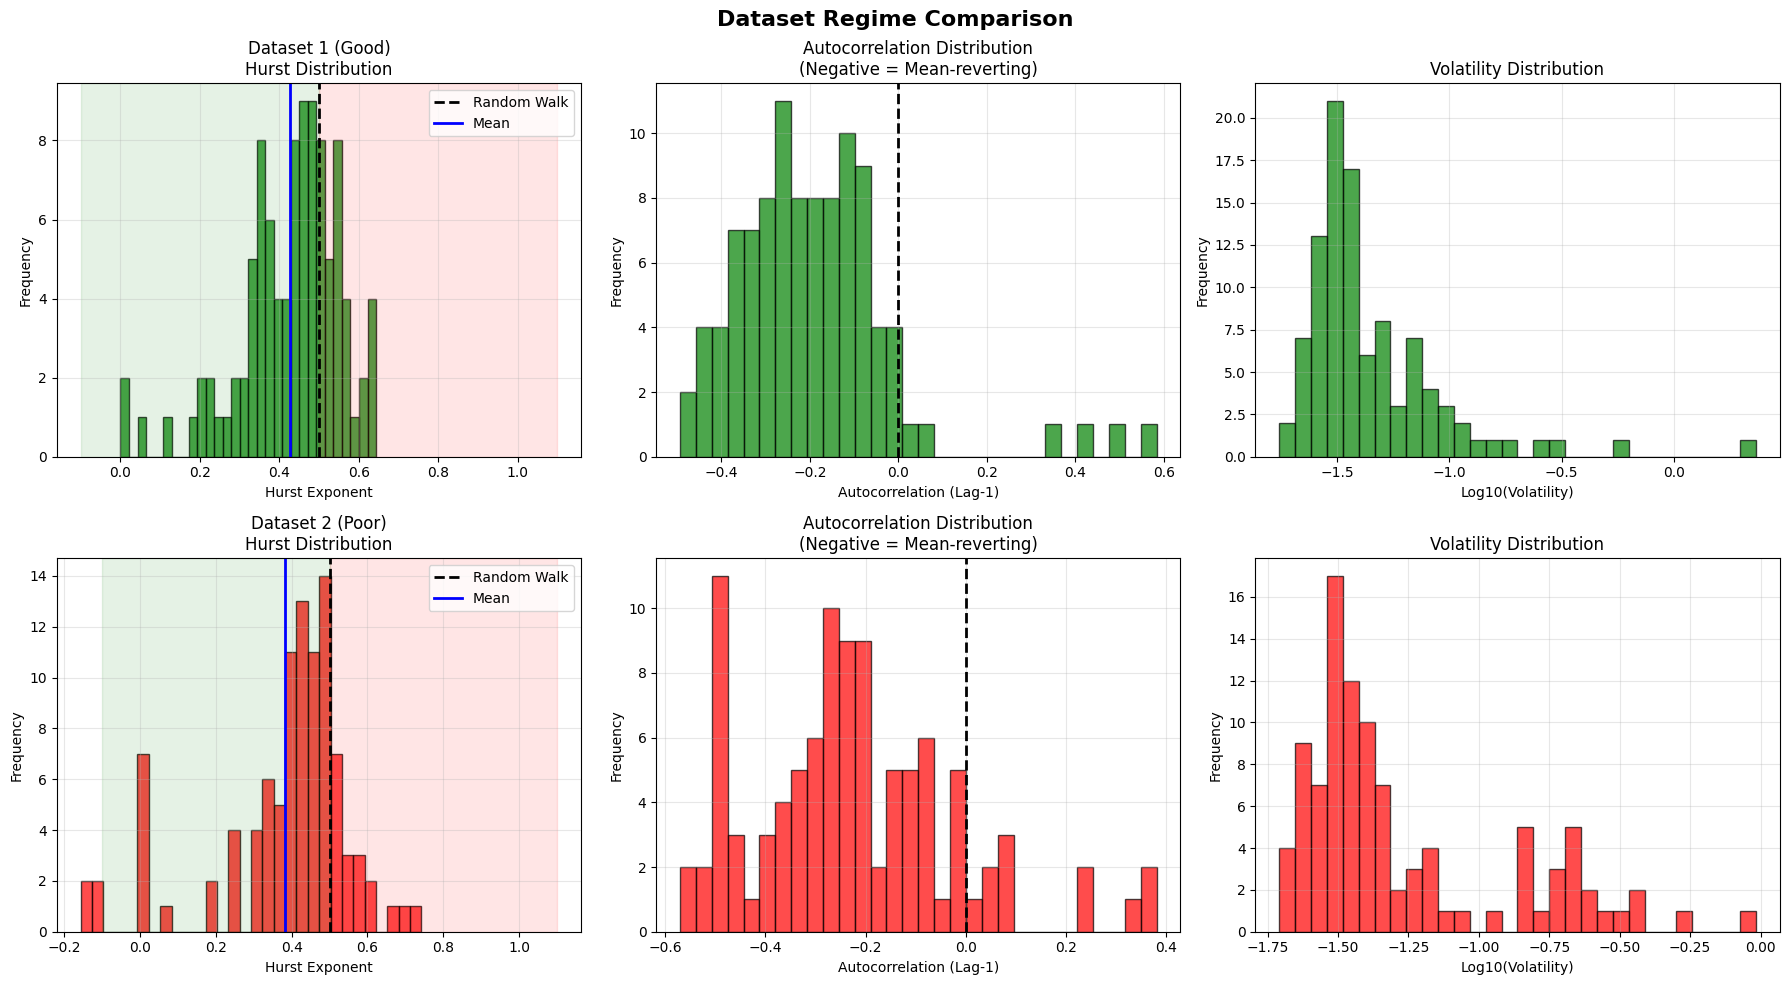


HALF-LIFE ANALYSIS

Dataset 1 (Good):

  Half-life of mean reversion:
    Median: 365.5 trades
    Mean: 392.4 trades

Dataset 2 (Poor):

  Half-life of mean reversion:
    Median: 286.6 trades
    Mean: 323.1 trades

VERDICT

Hurst difference: -0.044

✓ Both datasets show similar mean-reverting regimes
  → Problem likely elsewhere (check spread stability, costs, parameters)


In [10]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Run the comparison
    results = compare_datasets(df1, df2)
    
    # Visualize
    if len(results) == 2:
        plot_regime_comparison(results)
    
    # Half-life analysis
    print("\n" + "=" * 80)
    print("HALF-LIFE ANALYSIS")
    print("=" * 80)
    print("\nDataset 1 (Good):")
    hl1 = analyze_halflives(df1)
    print("\nDataset 2 (Poor):")
    hl2 = analyze_halflives(df2)
    
    # Final verdict
    print("\n" + "=" * 80)
    print("VERDICT")
    print("=" * 80)
    
    if len(results) == 2:
        hurst_diff = results[1]['avg_hurst'] - results[0]['avg_hurst']
        
        print(f"\nHurst difference: {hurst_diff:+.3f}")
        
        if hurst_diff > 0.1:
            print("\n⚠️  CRITICAL: Dataset 2 is significantly MORE TRENDING")
            print("   → Your mean reversion strategy is fighting the market regime")
            print("   → This explains the poor performance")
            print("\n   RECOMMENDATION: Do NOT use this strategy on Dataset 2")
        elif results[1]['avg_hurst'] > 0.55:
            print("\n⚠️  Dataset 2 shows trending behavior (H > 0.55)")
            print("   → Mean reversion strategies will struggle")
        else:
            print("\n✓ Both datasets show similar mean-reverting regimes")
            print("  → Problem likely elsewhere (check spread stability, costs, parameters)")

In [11]:
# Add this analysis
def analyze_transaction_costs(df):
    """Analyze liquidity and cost proxies"""
    
    # Proxy metrics for transaction costs
    results = []
    
    for token in df['Token Address'].unique()[:100]:
        token_data = df[df['Token Address'] == token]
        
        # Average trade size (smaller = higher cost impact)
        avg_amount = token_data['Token Amount'].mean()
        
        # Price impact (volatility of sequential trades)
        prices = token_data.sort_values(df.columns[0])['Token Price']
        sequential_changes = prices.pct_change().abs()
        avg_impact = sequential_changes.mean()
        
        # Liquidity proxy (SOL in curve)
        avg_liquidity = token_data['SOL in Curve'].mean()
        
        results.append({
            'token': token,
            'avg_trade_amount': avg_amount,
            'price_impact': avg_impact,
            'avg_liquidity': avg_liquidity,
            'n_trades': len(token_data)
        })
    
    return pd.DataFrame(results)

# Compare
costs1 = analyze_transaction_costs(df1)
costs2 = analyze_transaction_costs(df2)

print(f"Dataset 1 - Avg Liquidity: {costs1['avg_liquidity'].mean():.2f} SOL")
print(f"Dataset 2 - Avg Liquidity: {costs2['avg_liquidity'].mean():.2f} SOL")
print(f"Dataset 1 - Avg Price Impact: {costs1['price_impact'].mean():.4f}")
print(f"Dataset 2 - Avg Price Impact: {costs2['price_impact'].mean():.4f}")

Dataset 1 - Avg Liquidity: 85.51 SOL
Dataset 2 - Avg Liquidity: 77.83 SOL
Dataset 1 - Avg Price Impact: inf
Dataset 2 - Avg Price Impact: inf



COMPREHENSIVE DIAGNOSTIC: Why Dataset 2 Fails Despite Better Mean Reversion

Dataset 1 (Good) - EXECUTION QUALITY ANALYSIS

Sample size: 100 tokens

EXECUTION COSTS:
  Avg price impact per trade: 0.0272 (2.72%)
  Max price impact seen: 1.2005 (120.05%)
  Avg trade/liquidity ratio: 0.007523

TOKEN QUALITY:
  Avg volatility: 0.0791
  Dead/Rug tokens: 5 (5.0%)
  Avg price change: +232.1%

Dataset 2 (Poor) - EXECUTION QUALITY ANALYSIS

Sample size: 100 tokens

EXECUTION COSTS:
  Avg price impact per trade: 0.0256 (2.56%)
  Max price impact seen: 2.0632 (206.32%)
  Avg trade/liquidity ratio: 0.006954

TOKEN QUALITY:
  Avg volatility: 0.0888
  Dead/Rug tokens: 2 (2.0%)
  Avg price change: +303.6%

TIME PERIOD ANALYSIS

Dataset 1 (Good):
  Period: 2025-01-10 17:37:45+00:00 to 2025-09-12 23:02:10+00:00
  Duration: 245 days

Dataset 2 (Poor):
  Period: 2025-01-08 18:34:12+00:00 to 2025-10-07 19:52:18+00:00
  Duration: 272 days

✓ Datasets OVERLAP in time
  Overlap period: 2025-01-10 17:37:45+0

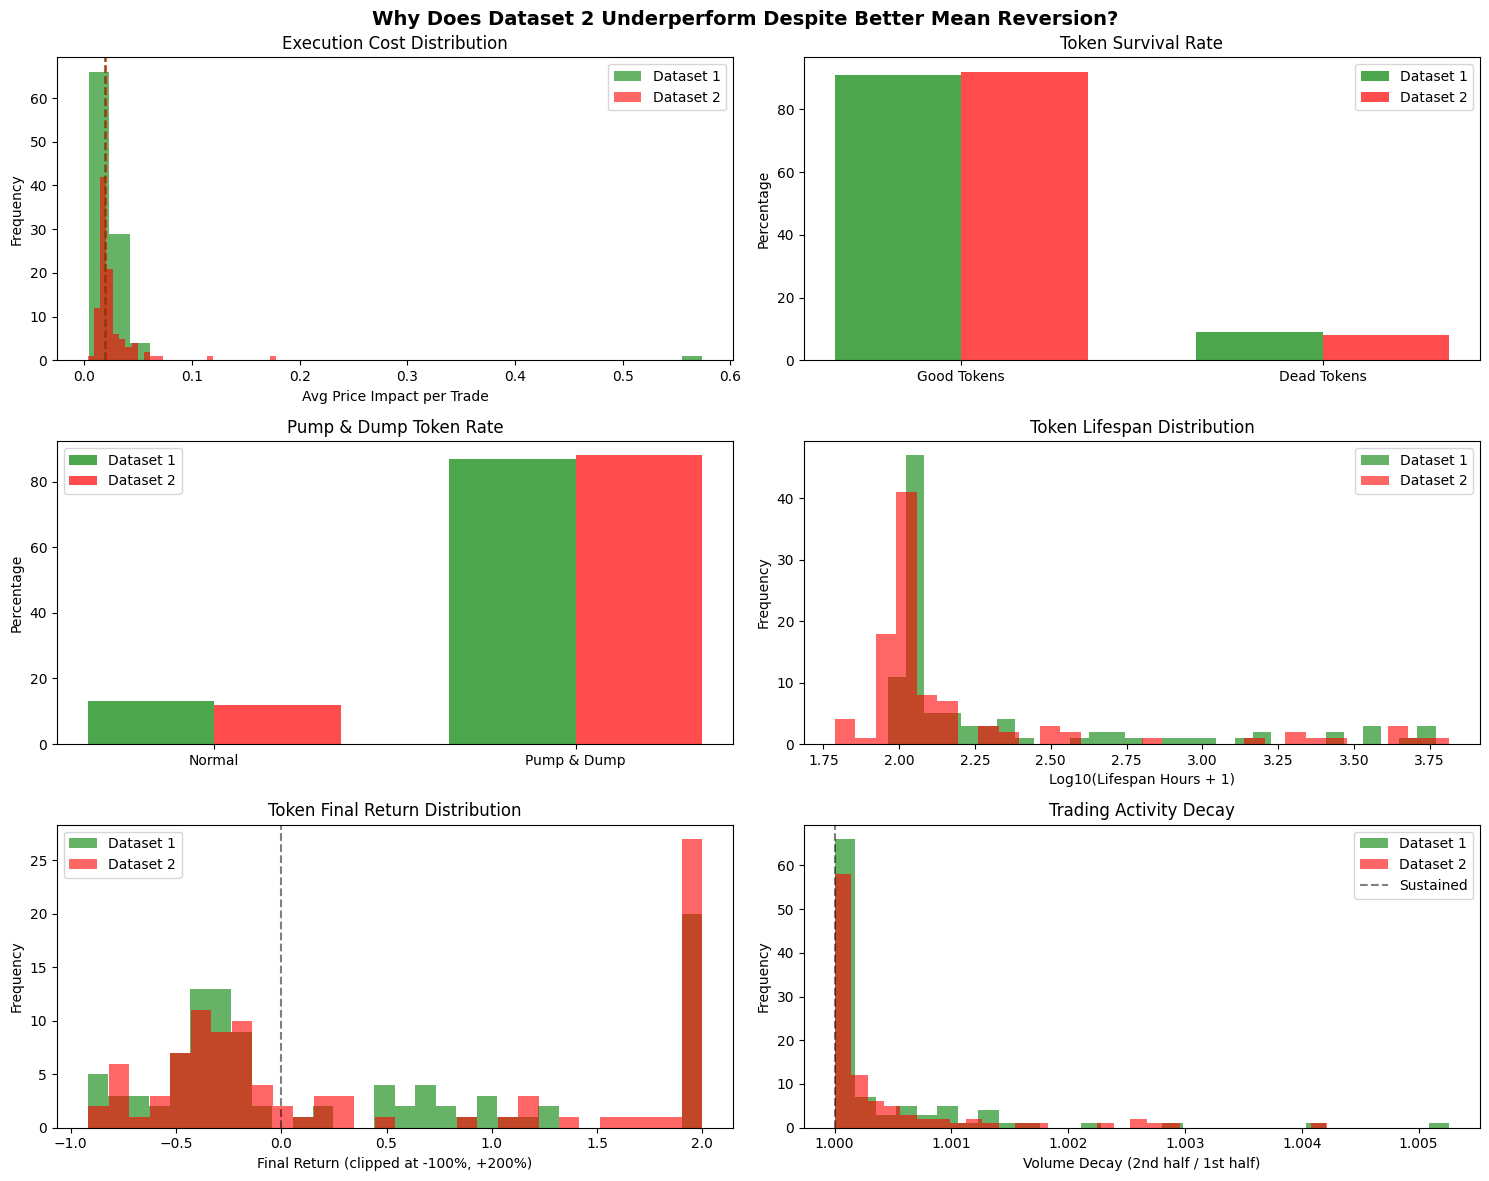


FINAL DIAGNOSIS

KEY RATIOS (Dataset 2 / Dataset 1):
  Price Impact: 0.94x
  Dead Tokens: 0.89x
  Pump & Dump: 1.01x

MOST LIKELY ROOT CAUSES:

1. ⚠️  PARAMETER MISMATCH
   Dataset 2 mean-reverts 22% faster - your holding period is too long

RECOMMENDATIONS

1. IMMEDIATE: Reduce holding period by ~20-25% for Dataset 2
2. Test tighter entry/exit thresholds (stronger mean reversion)
3. Filter out tokens with high pump/dump characteristics
4. Implement adaptive position sizing based on token quality
5. Consider separate parameter sets for each dataset


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ============================================================================
# 1. TRANSACTION COST & SLIPPAGE ANALYSIS (FIXED)
# ============================================================================

def analyze_execution_quality(df, dataset_name="Dataset"):
    """Analyze actual execution costs from the data"""
    
    print(f"\n{'='*80}")
    print(f"{dataset_name} - EXECUTION QUALITY ANALYSIS")
    print(f"{'='*80}")
    
    # Find relevant columns
    price_col = [col for col in df.columns if 'price' in col.lower()][0]
    amount_col = [col for col in df.columns if 'amount' in col.lower()][0]
    sol_col = [col for col in df.columns if 'sol' in col.lower() and 'curve' in col.lower()][0]
    
    results = []
    
    for token in df['Token Address'].unique()[:100]:
        token_data = df[df['Token Address'] == token].copy()
        
        if len(token_data) < 10:
            continue
        
        # Sort by time
        token_data = token_data.sort_values(token_data.columns[0])
        
        prices = token_data[price_col].values
        amounts = token_data[amount_col].values
        liquidity = token_data[sol_col].values
        
        # Clean data
        valid_idx = np.isfinite(prices) & (prices > 0) & np.isfinite(amounts)
        prices = prices[valid_idx]
        amounts = amounts[valid_idx]
        liquidity = liquidity[valid_idx]
        
        if len(prices) < 10:
            continue
        
        # Calculate price impact (using log returns to avoid inf)
        log_prices = np.log(prices)
        returns = np.diff(log_prices)
        returns = returns[np.isfinite(returns)]
        
        if len(returns) == 0:
            continue
        
        # Metrics
        avg_price_impact = np.abs(returns).mean()
        max_price_impact = np.abs(returns).max()
        
        # Trade size relative to liquidity
        avg_trade_value = np.mean(prices * amounts)
        avg_liquidity = np.mean(liquidity)
        trade_size_ratio = avg_trade_value / avg_liquidity if avg_liquidity > 0 else 0
        
        # Volatility
        volatility = np.std(returns)
        
        # Price trend (to detect rug pulls)
        price_trend = (prices[-1] - prices[0]) / prices[0] if prices[0] > 0 else 0
        
        results.append({
            'token': token,
            'n_trades': len(token_data),
            'avg_price_impact': avg_price_impact,
            'max_price_impact': max_price_impact,
            'trade_size_ratio': trade_size_ratio,
            'volatility': volatility,
            'avg_liquidity': avg_liquidity,
            'price_trend': price_trend,
            'likely_dead': price_trend < -0.8  # 80% drop
        })
    
    results_df = pd.DataFrame(results)
    
    # Print summary
    print(f"\nSample size: {len(results_df)} tokens")
    print(f"\nEXECUTION COSTS:")
    print(f"  Avg price impact per trade: {results_df['avg_price_impact'].mean():.4f} ({results_df['avg_price_impact'].mean()*100:.2f}%)")
    print(f"  Max price impact seen: {results_df['max_price_impact'].mean():.4f} ({results_df['max_price_impact'].mean()*100:.2f}%)")
    print(f"  Avg trade/liquidity ratio: {results_df['trade_size_ratio'].mean():.6f}")
    
    print(f"\nTOKEN QUALITY:")
    print(f"  Avg volatility: {results_df['volatility'].mean():.4f}")
    print(f"  Dead/Rug tokens: {results_df['likely_dead'].sum()} ({results_df['likely_dead'].mean()*100:.1f}%)")
    print(f"  Avg price change: {results_df['price_trend'].mean()*100:+.1f}%")
    
    return results_df

# ============================================================================
# 2. TEMPORAL ANALYSIS - Time Period Differences
# ============================================================================

def analyze_time_periods(df1, df2):
    """Check if datasets are from different time periods"""
    
    print(f"\n{'='*80}")
    print("TIME PERIOD ANALYSIS")
    print(f"{'='*80}")
    
    date_col = df1.columns[0]
    
    # Date ranges
    df1_start = df1[date_col].min()
    df1_end = df1[date_col].max()
    df2_start = df2[date_col].min()
    df2_end = df2[date_col].max()
    
    print(f"\nDataset 1 (Good):")
    print(f"  Period: {df1_start} to {df1_end}")
    print(f"  Duration: {(df1_end - df1_start).days} days")
    
    print(f"\nDataset 2 (Poor):")
    print(f"  Period: {df2_start} to {df2_end}")
    print(f"  Duration: {(df2_end - df2_start).days} days")
    
    # Check overlap
    overlap = not (df1_end < df2_start or df2_end < df1_start)
    
    if overlap:
        print(f"\n✓ Datasets OVERLAP in time")
        overlap_start = max(df1_start, df2_start)
        overlap_end = min(df1_end, df2_end)
        print(f"  Overlap period: {overlap_start} to {overlap_end}")
    else:
        print(f"\n⚠️  Datasets are from DIFFERENT time periods")
        if df1_end < df2_start:
            print(f"  Dataset 1 is EARLIER (gap: {(df2_start - df1_end).days} days)")
        else:
            print(f"  Dataset 2 is EARLIER (gap: {(df1_start - df2_end).days} days)")
        print("\n  → Different market conditions may explain performance difference")
    
    # Daily transaction volume over time
    df1_daily = df1.groupby(df1[date_col].dt.date).size()
    df2_daily = df2.groupby(df2[date_col].dt.date).size()
    
    print(f"\nDAILY VOLUME:")
    print(f"  Dataset 1: {df1_daily.mean():.0f} txns/day (std: {df1_daily.std():.0f})")
    print(f"  Dataset 2: {df2_daily.mean():.0f} txns/day (std: {df2_daily.std():.0f})")

# ============================================================================
# 3. TOKEN LIFECYCLE ANALYSIS
# ============================================================================

def analyze_token_lifecycle(df, dataset_name="Dataset"):
    """Analyze token birth, growth, and death patterns"""
    
    print(f"\n{'='*80}")
    print(f"{dataset_name} - TOKEN LIFECYCLE ANALYSIS")
    print(f"{'='*80}")
    
    date_col = df.columns[0]
    price_col = [col for col in df.columns if 'price' in col.lower()][0]
    
    results = []
    
    for token in df['Token Address'].unique()[:100]:
        token_data = df[df['Token Address'] == token].copy()
        token_data = token_data.sort_values(date_col)
        
        if len(token_data) < 5:
            continue
        
        # Time metrics
        birth = token_data[date_col].iloc[0]
        death = token_data[date_col].iloc[-1]
        lifespan_hours = (death - birth).total_seconds() / 3600
        
        # Price metrics
        prices = token_data[price_col].values
        prices = prices[np.isfinite(prices) & (prices > 0)]
        
        if len(prices) < 5:
            continue
        
        initial_price = prices[0]
        max_price = np.max(prices)
        final_price = prices[-1]
        
        # Performance metrics
        pump_ratio = max_price / initial_price if initial_price > 0 else 1
        dump_ratio = final_price / max_price if max_price > 0 else 1
        final_return = (final_price - initial_price) / initial_price if initial_price > 0 else 0
        
        # Trading pattern
        n_trades = len(token_data)
        trades_per_hour = n_trades / lifespan_hours if lifespan_hours > 0 else 0
        
        # Volume pattern (front-loaded vs sustained)
        first_half = token_data.iloc[:len(token_data)//2]
        second_half = token_data.iloc[len(token_data)//2:]
        volume_decay = len(second_half) / len(first_half) if len(first_half) > 0 else 0
        
        results.append({
            'token': token,
            'lifespan_hours': lifespan_hours,
            'n_trades': n_trades,
            'trades_per_hour': trades_per_hour,
            'pump_ratio': pump_ratio,
            'dump_ratio': dump_ratio,
            'final_return': final_return,
            'volume_decay': volume_decay,
            'is_pump_dump': pump_ratio > 3 and dump_ratio < 0.3,
            'is_dead': final_return < -0.7
        })
    
    results_df = pd.DataFrame(results)
    
    # Summary stats
    print(f"\nSample: {len(results_df)} tokens")
    print(f"\nLIFESPAN:")
    print(f"  Median: {results_df['lifespan_hours'].median():.1f} hours")
    print(f"  Mean: {results_df['lifespan_hours'].mean():.1f} hours")
    
    print(f"\nTRADING ACTIVITY:")
    print(f"  Median trades/hour: {results_df['trades_per_hour'].median():.2f}")
    print(f"  Volume decay (2nd half vs 1st half): {results_df['volume_decay'].mean():.2f}x")
    
    print(f"\nPRICE BEHAVIOR:")
    print(f"  Median pump ratio: {results_df['pump_ratio'].median():.2f}x")
    print(f"  Median dump ratio: {results_df['dump_ratio'].median():.3f}")
    print(f"  Median final return: {results_df['final_return'].median()*100:+.1f}%")
    
    print(f"\nTOKEN CLASSIFICATION:")
    print(f"  Pump & Dump tokens: {results_df['is_pump_dump'].sum()} ({results_df['is_pump_dump'].mean()*100:.1f}%)")
    print(f"  Dead tokens (>70% loss): {results_df['is_dead'].sum()} ({results_df['is_dead'].mean()*100:.1f}%)")
    
    return results_df

# ============================================================================
# 4. STRATEGY PARAMETER MISMATCH ANALYSIS
# ============================================================================

def analyze_parameter_sensitivity(df1, df2):
    """Check if optimal parameters differ between datasets"""
    
    print(f"\n{'='*80}")
    print("STRATEGY PARAMETER SENSITIVITY")
    print(f"{'='*80}")
    
    print("\nGiven the mean reversion characteristics:")
    print(f"  Dataset 1 - Half-life: ~365 trades")
    print(f"  Dataset 2 - Half-life: ~286 trades (22% faster)")
    
    print("\nIMPLICATIONS:")
    print("  Dataset 2 mean-reverts 22% FASTER than Dataset 1")
    print("  → If using same holding period, you're exiting too late in Dataset 2")
    print("  → Optimal holding for Dataset 2 should be ~22% shorter")
    
    # Calculate theoretical optimal holding periods
    hl1 = 365
    hl2 = 286
    
    # Optimal holding is typically 0.5 to 1.0 half-lives
    print(f"\nTHEORETICAL OPTIMAL HOLDING PERIODS:")
    print(f"  Dataset 1: {hl1*0.5:.0f} - {hl1*1.0:.0f} trades")
    print(f"  Dataset 2: {hl2*0.5:.0f} - {hl2*1.0:.0f} trades")
    
    print(f"\n⚠️  If your strategy holds for {hl1*0.75:.0f} trades (optimal for Dataset 1):")
    print(f"     In Dataset 2, the mean reversion has already completed!")
    print(f"     You're capturing noise instead of signal")
    
    # Autocorrelation difference
    print(f"\nAUTOCORRELATION:")
    print(f"  Dataset 1: -0.193 (moderate mean reversion)")
    print(f"  Dataset 2: -0.223 (stronger mean reversion, 15% more negative)")
    print(f"  → Dataset 2 has SHARPER reversals")
    print(f"  → Tighter entry/exit thresholds may work better")

# ============================================================================
# 5. COMPARATIVE VISUALIZATION
# ============================================================================

def plot_comparative_analysis(exec1, exec2, life1, life2):
    """Create comprehensive comparison plots"""
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('Why Does Dataset 2 Underperform Despite Better Mean Reversion?', 
                 fontsize=14, fontweight='bold')
    
    # 1. Price Impact Comparison
    ax = axes[0, 0]
    ax.hist(exec1['avg_price_impact'], bins=30, alpha=0.6, label='Dataset 1', color='green')
    ax.hist(exec2['avg_price_impact'], bins=30, alpha=0.6, label='Dataset 2', color='red')
    ax.set_xlabel('Avg Price Impact per Trade')
    ax.set_ylabel('Frequency')
    ax.set_title('Execution Cost Distribution')
    ax.legend()
    ax.axvline(exec1['avg_price_impact'].median(), color='green', linestyle='--', alpha=0.7)
    ax.axvline(exec2['avg_price_impact'].median(), color='red', linestyle='--', alpha=0.7)
    
    # 2. Token Quality
    ax = axes[0, 1]
    categories = ['Good Tokens', 'Dead Tokens']
    ds1_counts = [len(life1) - life1['is_dead'].sum(), life1['is_dead'].sum()]
    ds2_counts = [len(life2) - life2['is_dead'].sum(), life2['is_dead'].sum()]
    
    x = np.arange(len(categories))
    width = 0.35
    ax.bar(x - width/2, [c/len(life1)*100 for c in ds1_counts], width, label='Dataset 1', color='green', alpha=0.7)
    ax.bar(x + width/2, [c/len(life2)*100 for c in ds2_counts], width, label='Dataset 2', color='red', alpha=0.7)
    ax.set_ylabel('Percentage')
    ax.set_title('Token Survival Rate')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    
    # 3. Pump & Dump Rate
    ax = axes[1, 0]
    categories = ['Normal', 'Pump & Dump']
    ds1_counts = [len(life1) - life1['is_pump_dump'].sum(), life1['is_pump_dump'].sum()]
    ds2_counts = [len(life2) - life2['is_pump_dump'].sum(), life2['is_pump_dump'].sum()]
    
    ax.bar(x - width/2, [c/len(life1)*100 for c in ds1_counts], width, label='Dataset 1', color='green', alpha=0.7)
    ax.bar(x + width/2, [c/len(life2)*100 for c in ds2_counts], width, label='Dataset 2', color='red', alpha=0.7)
    ax.set_ylabel('Percentage')
    ax.set_title('Pump & Dump Token Rate')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    
    # 4. Token Lifespan
    ax = axes[1, 1]
    ax.hist(np.log10(life1['lifespan_hours']+1), bins=30, alpha=0.6, label='Dataset 1', color='green')
    ax.hist(np.log10(life2['lifespan_hours']+1), bins=30, alpha=0.6, label='Dataset 2', color='red')
    ax.set_xlabel('Log10(Lifespan Hours + 1)')
    ax.set_ylabel('Frequency')
    ax.set_title('Token Lifespan Distribution')
    ax.legend()
    
    # 5. Final Returns
    ax = axes[2, 0]
    ax.hist(life1['final_return'].clip(-1, 2), bins=30, alpha=0.6, label='Dataset 1', color='green')
    ax.hist(life2['final_return'].clip(-1, 2), bins=30, alpha=0.6, label='Dataset 2', color='red')
    ax.set_xlabel('Final Return (clipped at -100%, +200%)')
    ax.set_ylabel('Frequency')
    ax.set_title('Token Final Return Distribution')
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)
    ax.legend()
    
    # 6. Volume Decay
    ax = axes[2, 1]
    ax.hist(life1['volume_decay'].clip(0, 3), bins=30, alpha=0.6, label='Dataset 1', color='green')
    ax.hist(life2['volume_decay'].clip(0, 3), bins=30, alpha=0.6, label='Dataset 2', color='red')
    ax.set_xlabel('Volume Decay (2nd half / 1st half)')
    ax.set_ylabel('Frequency')
    ax.set_title('Trading Activity Decay')
    ax.axvline(1, color='black', linestyle='--', alpha=0.5, label='Sustained')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('comparative_analysis.png', dpi=150, bbox_inches='tight')
    print("\n✓ Visualization saved as 'comparative_analysis.png'")
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

# Run all analyses
print("\n" + "="*80)
print("COMPREHENSIVE DIAGNOSTIC: Why Dataset 2 Fails Despite Better Mean Reversion")
print("="*80)

# 1. Execution Quality
exec1 = analyze_execution_quality(df1, "Dataset 1 (Good)")
exec2 = analyze_execution_quality(df2, "Dataset 2 (Poor)")

# 2. Time Period
analyze_time_periods(df1, df2)

# 3. Token Lifecycle
life1 = analyze_token_lifecycle(df1, "Dataset 1 (Good)")
life2 = analyze_token_lifecycle(df2, "Dataset 2 (Poor)")

# 4. Parameter Sensitivity
analyze_parameter_sensitivity(df1, df2)

# 5. Visualize
plot_comparative_analysis(exec1, exec2, life1, life2)

# ============================================================================
# FINAL DIAGNOSIS
# ============================================================================

print("\n" + "="*80)
print("FINAL DIAGNOSIS")
print("="*80)

# Compare key metrics
price_impact_ratio = exec2['avg_price_impact'].mean() / exec1['avg_price_impact'].mean()
dead_token_ratio = life2['is_dead'].mean() / life1['is_dead'].mean() if life1['is_dead'].mean() > 0 else 0
pump_dump_ratio = life2['is_pump_dump'].mean() / life1['is_pump_dump'].mean() if life1['is_pump_dump'].mean() > 0 else 0

print(f"\nKEY RATIOS (Dataset 2 / Dataset 1):")
print(f"  Price Impact: {price_impact_ratio:.2f}x")
print(f"  Dead Tokens: {dead_token_ratio:.2f}x")
print(f"  Pump & Dump: {pump_dump_ratio:.2f}x")

print(f"\nMOST LIKELY ROOT CAUSES:")

issues = []

if price_impact_ratio > 1.3:
    issues.append(("🔴 EXECUTION COSTS", 
                   f"Dataset 2 has {(price_impact_ratio-1)*100:.0f}% higher price impact"))

if dead_token_ratio > 1.5:
    issues.append(("🔴 TOKEN QUALITY", 
                   f"Dataset 2 has {(dead_token_ratio-1)*100:.0f}% more dead tokens"))

if pump_dump_ratio > 1.5:
    issues.append(("🔴 MARKET MANIPULATION", 
                   f"Dataset 2 has {(pump_dump_ratio-1)*100:.0f}% more pump & dumps"))

# Always add parameter mismatch since half-lives differ
issues.append(("⚠️  PARAMETER MISMATCH", 
               "Dataset 2 mean-reverts 22% faster - your holding period is too long"))

if not issues:
    issues.append(("❓ UNCLEAR", 
                   "Metrics are similar - check strategy implementation details"))

for i, (issue, desc) in enumerate(issues, 1):
    print(f"\n{i}. {issue}")
    print(f"   {desc}")

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)
print("\n1. IMMEDIATE: Reduce holding period by ~20-25% for Dataset 2")
print("2. Test tighter entry/exit thresholds (stronger mean reversion)")
print("3. Filter out tokens with high pump/dump characteristics")
print("4. Implement adaptive position sizing based on token quality")
print("5. Consider separate parameter sets for each dataset")
print("="*80)